# Reproducible Analysis


In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import re
import string
import unicodedata
from bs4 import BeautifulSoup

from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import time
import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
import spacy
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.tokenize.stanford import StanfordTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# read the first dataset from inside airbnb London

# path = '.../data/raw'

df_1 = pd.read_csv(os.path.join('data','raw','reviews.csv.gz'), low_memory=False)


In [3]:
# checking shape of df_1
print("The dataset has {} rows and {} columns.".format(*df_1.shape))

# checking duplicates
print("It contains {} duplicates.".format(df_1.duplicated().sum()))

The dataset has 1178933 rows and 6 columns.
It contains 0 duplicates.


In [4]:
df_1.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,11551,30672,2010-03-21,93896,Shar-Lyn,"The flat was bright, comfortable and clean and..."
1,11551,32236,2010-03-29,97890,Zane,We stayed with Adriano and Valerio for a week ...
2,11551,41044,2010-05-09,104133,Chase,Adriano was a fantastic host. We felt very at ...
3,11551,48926,2010-06-01,122714,John & Sylvia,We had a most wonderful stay with Adriano and ...
4,11551,58352,2010-06-28,111543,Monique,I'm not sure which of us misunderstood the s...


In [5]:
# it may be valuable to have more details, such as the latitude and longitude of the accommodation that has been reviewed, 
# the neighbourhood it's in, the host id, etc.
df_2 = pd.read_csv(os.path.join('data','raw','listings.csv.gz'), low_memory=False)

df_2.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20201216161425,2021-01-04,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,...,10.0,9.0,9.0,NaN,t,2,2,0,0,1.46
1,13913,https://www.airbnb.com/rooms/13913,20201216161425,2020-12-18,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,...,10.0,9.0,9.0,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20201216161425,2020-12-28,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,...,10.0,10.0,9.0,NaN,t,1,1,0,0,0.66
3,17402,https://www.airbnb.com/rooms/17402,20201216161425,2020-12-19,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,"Location, location, location! You won't find b...",https://a0.muscache.com/pictures/39d5309d-fba7...,67564,https://www.airbnb.com/users/show/67564,...,9.0,10.0,9.0,NaN,f,15,15,0,0,0.35
4,17506,https://www.airbnb.com/rooms/17506,20201216161425,2020-12-18,Boutique Chelsea/Fulham Double bed 5-star ensuite,Enjoy a chic stay in this elegant but fully mo...,Fulham is 'villagey' and residential – a real ...,https://a0.muscache.com/pictures/11901327/e63d...,67915,https://www.airbnb.com/users/show/67915,...,NaN,NaN,NaN,NaN,f,2,0,2,0,NaN


In [6]:
# merging full df_1 + add only specific columns from df_2
df = pd.merge(df_1, df_2[['neighbourhood_cleansed', 'host_id', 'latitude',
                          'longitude', 'number_of_reviews', 'id', 'property_type']], 
              left_on='listing_id', right_on='id', how='left')


df.drop(['id_y'], axis=1, inplace=True)

In [7]:
df.head(3)

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,neighbourhood_cleansed,host_id,latitude,longitude,number_of_reviews,property_type
0,11551,30672,2010-03-21,93896,Shar-Lyn,"The flat was bright, comfortable and clean and...",Lambeth,43039,51.46225,-0.11732,192,Entire apartment
1,11551,32236,2010-03-29,97890,Zane,We stayed with Adriano and Valerio for a week ...,Lambeth,43039,51.46225,-0.11732,192,Entire apartment
2,11551,41044,2010-05-09,104133,Chase,Adriano was a fantastic host. We felt very at ...,Lambeth,43039,51.46225,-0.11732,192,Entire apartment


In [8]:
# checking shape of shape
print("The dataset has {} rows and {} columns.".format(*df.shape))

The dataset has 1178933 rows and 12 columns.


In [9]:
# Incidentally, most of the ghost hotels are run professionally by companies or private trustees through Airbnb, 
# so it is now trying to get a rough estimate of how many ghost makers there are.
# group by hosts and count the number of unique listings --> cast it to a dataframe
properties_per_host = pd.DataFrame(df.groupby('host_id')['listing_id'].nunique())

# sort unique values descending and show the Top20
properties_per_host.sort_values(by=['listing_id'], ascending=False, inplace=True)
properties_per_host.head(10)

,listing_id
host_id,
33889201,352
28820321,219
48165024,155
13557337,141
224866971,130
27572615,99
205256737,94
83740964,87
1432477,87


In [10]:
# I found out that the first place host_id has 718 listings.
# I'm curious if he owns a private apartment or a hostel
top1_host = df.host_id == 33889201
df[top1_host].neighbourhood_cleansed.value_counts()

pd.DataFrame(df[top1_host].groupby('neighbourhood_cleansed')['listing_id'].nunique())


,listing_id
neighbourhood_cleansed,
Barnet,1
Brent,14
Camden,34
City of London,1
Ealing,3
Greenwich,3
Hackney,10
Hammersmith and Fulham,44
Haringey,4


In [11]:
pd.DataFrame(df[top1_host].groupby('property_type')['listing_id'].nunique())


,listing_id
property_type,
Entire apartment,180
Entire house,171
Entire loft,1


In [12]:
# it can be found that half of his rental properties are 
# entire apartments and the other half are entire houses
# and this host owns properties in 19 boroughs.
# Now let's look at the top-2 host.

In [13]:
top2_host = df.host_id == 28820321
df[top2_host].neighbourhood_cleansed.value_counts()

pd.DataFrame(df[top2_host].groupby('neighbourhood_cleansed')['listing_id'].nunique())

,listing_id
neighbourhood_cleansed,
Barnet,5
Brent,8
Bromley,1
Camden,18
Croydon,1
Ealing,1
Greenwich,4
Hackney,22
Hammersmith and Fulham,9


In [14]:
pd.DataFrame(df[top2_host].groupby('property_type')['listing_id'].nunique())


,listing_id
property_type,
Entire apartment,178
Entire house,36
Entire loft,1
Entire place,1
Private room in townhouse,3


In [15]:
# This host is renting out a complex range of properties
# Now the report is going to prepross and clean the data

# other text cleaning and preprocessing
# Step 1 - Remove the missing data (NA)
# Step 2 - Remove puncutations, numbers
# Step 3 - Remove the stopwords
# Step 4 - Visualizing the Data with WordClouds

# but i should read boroughs information first.
boros = gpd.read_file('https://github.com/Zihaoli617/i2p_final_assessment/blob/main/Boroughs.gpkg?raw=true')


In [16]:
# drop out the missing data
df.drop(df[((df.latitude.isna())|(df.longitude.isna()))].index, axis=0, inplace=True)
df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
print(df.shape)

df.drop(index=(df[(df.comments.isna()) | 
                  (df.neighbourhood_cleansed.isna()) |
                  (df.reviewer_name.isna())].index), inplace=True)
print(df.shape)

(1178933, 12)
(1178411, 12)


In [17]:
# and i do not need so much data for the further anlysis
df = df.sample(frac=0.2)

print(df.shape)

(235682, 12)


In [18]:
# remove punctuation
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;]+')
punkt   = []
for c in df:
    punkt.append(re.sub(pattern, ' ', c))

In [19]:
# Removing Stopword
from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))
stopped = []
for p in punkt:
    stopped.append(' '.join([x for x in re.split(r'\s+', p) if x not in stopword_list]))

In [20]:
# check missing data
df.isna().sum()

listing_id                0
id_x                      0
date                      0
reviewer_id               0
reviewer_name             0
comments                  0
neighbourhood_cleansed    0
host_id                   0
latitude                  0
longitude                 0
number_of_reviews         0
property_type             0
dtype: int64

In [21]:
# remove them
df.dropna(inplace=True)
df.isna().sum()
print(df.shape)

(235682, 12)


In [22]:
# Visualizing the Data with WordClouds
# import other necessary libraries
from collections import Counter
from PIL import Image

In [23]:
# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.show()


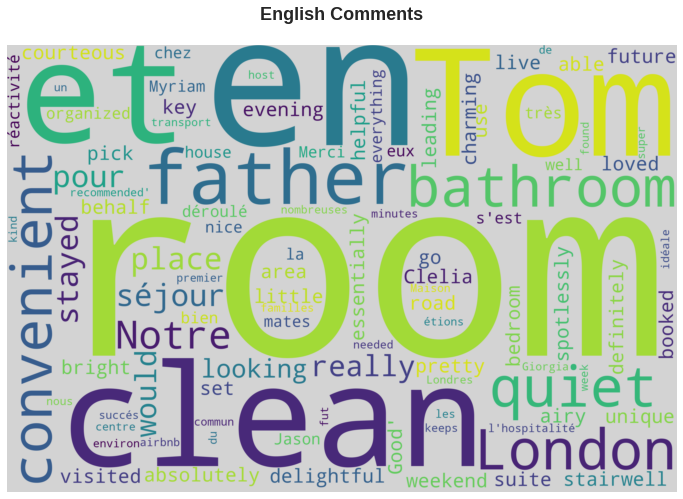

In [24]:
wordcloud = WordCloud(max_font_size=None, max_words=100, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english','german')).generate(str(df.comments.values))

plot_wordcloud(wordcloud, "English")

In [25]:
# it can be found that there is any other language - non-english
# Language Detection
!pip install langdetect

from langdetect import detect

In [26]:
# write the function that detects the language
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [28]:
# CPU times: user 10min 55s, sys: 45.9 s, total: 11min 41s
# Wall time: 11min 41s

df['language'] = df['comments'].apply(language_detection)

In [30]:
df.language.value_counts().head(10)

en       205153
fr        10341
es         5017
de         3548
it         2420
ko         1811
zh-cn      1370
pt          889
nl          688
ro          526
Name: language, dtype: int64

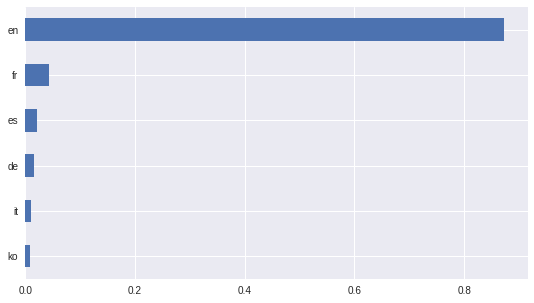

In [31]:
# visualizing the comments' languages
ax = df.language.value_counts(normalize=True).head(6).sort_values().plot(kind='barh', figsize=(9,5));

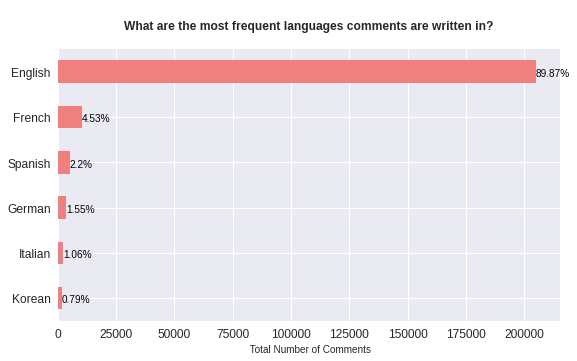

In [32]:
# visualizing the comments' languages in another way
ax = df.language.value_counts().head(6).plot(kind='barh', figsize=(9,5), color="lightcoral", 
                                             fontsize=12);

ax.set_title("\nWhat are the most frequent languages comments are written in?\n", 
             fontsize=12, fontweight='bold')
ax.set_xlabel(" Total Number of Comments", fontsize=10)
ax.set_yticklabels(['English','French', 'Spanish', 'German', 'Italian', 'Korean'])

# create a list to collect the plt.patches data
totals = []
# find the ind. values and append to list
for i in ax.patches:
    totals.append(i.get_width())
# get total
total = sum(totals)

# set individual bar labels using above list
for i in ax.patches:
    ax.text(x=i.get_width(), y=i.get_y()+.35, 
            s=str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=10, color='black')

# invert for largest on top 
ax.invert_yaxis()

plt.savefig('data/raw/languages_comments.png')

In [33]:
# splitting the dataframes in language related sub-dataframes
# in this report, English should be the better for my analysis so
df_eng = df[(df['language']=='en')]

In [34]:
# in this part, i will make a better wordcloud
from collections import Counter
from PIL import Image

In [35]:
# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.show()

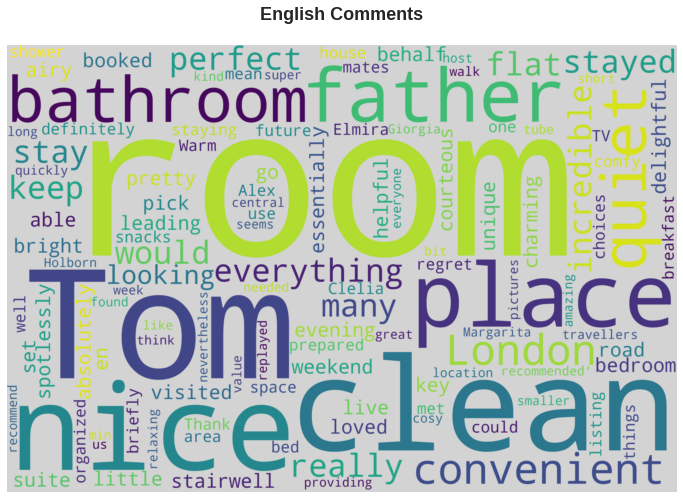

In [36]:
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(df_eng.comments.values))

plot_wordcloud(wordcloud, 'English')

In [37]:
# Sentiment Analysis
# load the SentimentIntensityAnalyser object in
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [38]:
# use the polarity_scores() method to get the sentiment metrics
def print_sentiment_scores(sentence):
    snt = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))

In [39]:
# getting only the negative score
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

# getting only the neutral score
def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

# getting only the positive score
def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

# getting only the compound score
def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

In [40]:
# Calculating Sentiment Scores
# it may spend 10 mins to run the conde or less
df = df_eng

df['sentiment_neg'] = df['comments'].apply(negative_score)
df['sentiment_neu'] = df['comments'].apply(neutral_score)
df['sentiment_pos'] = df['comments'].apply(positive_score)
df['sentiment_compound'] = df['comments'].apply(compound_score)

In [41]:
df.head(3)

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,neighbourhood_cleansed,host_id,latitude,longitude,number_of_reviews,property_type,language,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
266906,5047528,28012848,2015-03-16,14967232,Genevieve,I booked Tom's room on behalf of my father who...,Hammersmith and Fulham,26058133,51.49831,-0.22790,36,Private room in house,en,0.000,0.710,0.290,0.9838
696478,18208697,151954899,2017-05-14,121033618,Iain,A clean and quiet room in a convenient area of...,Islington,81237284,51.55977,-0.11898,3,Private room in apartment,en,0.000,0.678,0.322,0.7650
518158,13589671,137735303,2017-03-17,14756053,Hugo Cesar,The space is perfect and no one staying there ...,Hillingdon,78477393,51.48260,-0.44594,388,Private room in apartment,en,0.042,0.642,0.316,0.9753


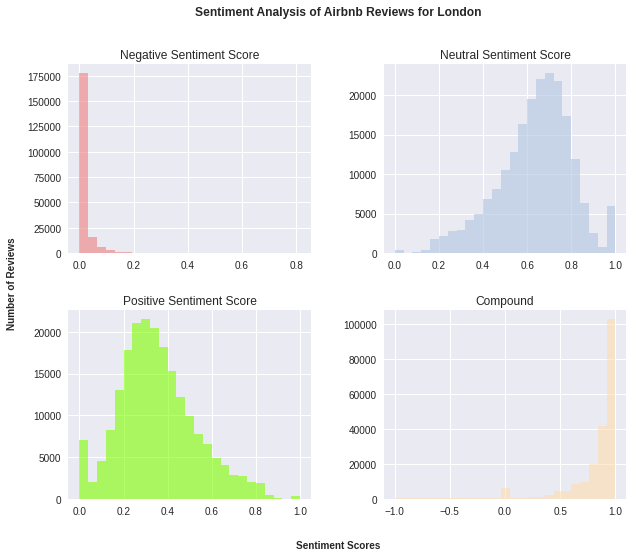

In [42]:
# all scores in 4 histograms
fig, axes = plt.subplots(2, 2, figsize=(10,8))

# plot all 4 histograms
df.hist('sentiment_neg', bins=25, ax=axes[0,0], color='lightcoral', alpha=0.6)
axes[0,0].set_title('Negative Sentiment Score')
df.hist('sentiment_neu', bins=25, ax=axes[0,1], color='lightsteelblue', alpha=0.6)
axes[0,1].set_title('Neutral Sentiment Score')
df.hist('sentiment_pos', bins=25, ax=axes[1,0], color='chartreuse', alpha=0.6)
axes[1,0].set_title('Positive Sentiment Score')
df.hist('sentiment_compound', bins=25, ax=axes[1,1], color='navajowhite', alpha=0.6)
axes[1,1].set_title('Compound')

# plot common x- and y-label
fig.text(0.5, 0.04, 'Sentiment Scores',  fontweight='bold', ha='center')
fig.text(0.04, 0.5, 'Number of Reviews', fontweight='bold', va='center', rotation='vertical')

# plot title
plt.suptitle('Sentiment Analysis of Airbnb Reviews for London\n\n', fontsize=12, fontweight='bold');


plt.savefig('data/raw/sentiment_analysis.png')

In [43]:
percentiles = df.sentiment_compound.describe(percentiles=[.05, .1, .2, .3, .4, .5, .6, .7, .8, .9])

percentiles

count    205153.000000
mean          0.822135
std           0.265410
min          -0.998300
5%            0.238200
10%           0.571900
20%           0.763900
30%           0.842500
40%           0.890300
50%           0.919900
60%           0.941100
70%           0.957200
80%           0.970100
90%           0.981700
max           0.999700
Name: sentiment_compound, dtype: float64

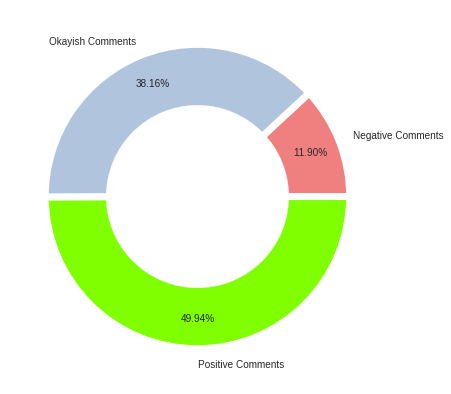

<Figure size 576x396 with 0 Axes>

In [44]:
# Comparing Negative and Positive Comments
# assign the data
neg = percentiles['5%']
mid = percentiles['20%']
pos = percentiles['max']
names = ['Negative Comments', 'Okayish Comments','Positive Comments']
size = [neg, mid, pos]

# call a pie chart
plt.pie(size, labels=names, colors=['lightcoral', 'lightsteelblue', 'chartreuse'], 
        autopct='%.2f%%', pctdistance=0.8,
        wedgeprops={'linewidth':7, 'edgecolor':'white' })

# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(7,7)
fig.gca().add_artist(my_circle)
plt.show()

plt.savefig('data/raw/comparing.png')



In [45]:
# full dataframe with POSITIVE comments
df_pos = df.loc[df.sentiment_compound >= 0.95]

# only corpus of POSITIVE comments
pos_comments = df_pos['comments'].tolist()

In [46]:
# full dataframe with NEGATIVE comments
df_neg = df.loc[df.sentiment_compound < 0.0]

# only corpus of NEGATIVE comments
neg_comments = df_neg['comments'].tolist()

In [47]:
df_pos['text_length'] = df_pos['comments'].apply(len)
df_neg['text_length'] = df_neg['comments'].apply(len)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


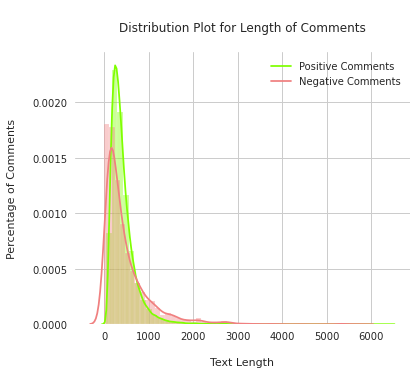

In [49]:
sns.set_style("whitegrid")
plt.figure(figsize=(6,5))

sns.distplot(df_pos['text_length'], kde=True, bins=50, color='chartreuse')
sns.distplot(df_neg['text_length'], kde=True, bins=50, color='lightcoral')

plt.title('\nDistribution Plot for Length of Comments\n')
plt.legend(['Positive Comments', 'Negative Comments'])
plt.xlabel('\nText Length')
plt.ylabel('Percentage of Comments\n');

plt.savefig('data/raw/distribution.png')

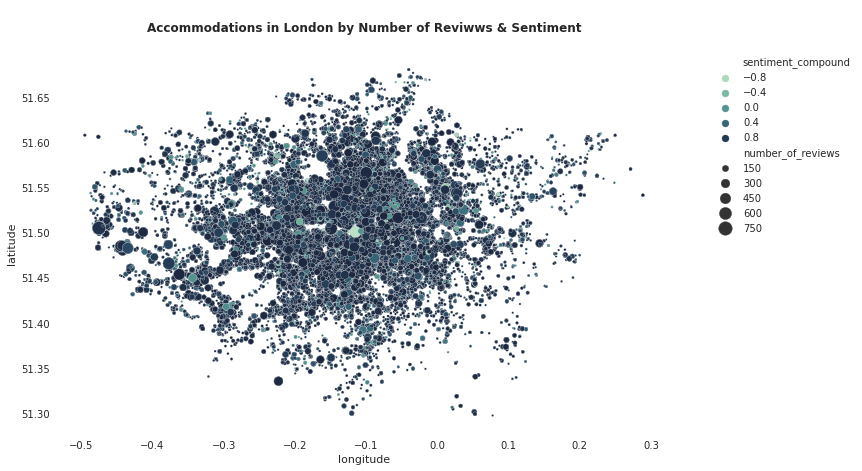

In [50]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True)
fig, ax = plt.subplots(figsize=(11,7))

ax = sns.scatterplot(x="longitude", y="latitude", size='number_of_reviews', sizes=(5, 200),
                     hue='sentiment_compound', palette=cmap,  data=df)
ax.legend(bbox_to_anchor=(1.3, 1), borderaxespad=0.)

plt.title('\nAccommodations in London by Number of Reviwws & Sentiment\n', fontsize=12, fontweight='bold')

sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

In [96]:
# Frequency Distribution
!pip install yellowbrick

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer
from yellowbrick.style import set_palette

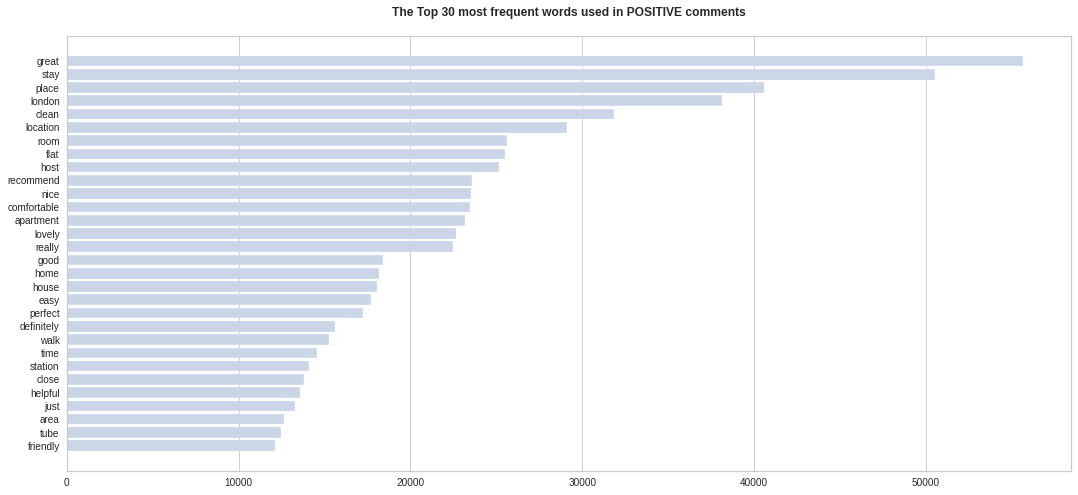

In [53]:
# vectorizing text
vectorizer = CountVectorizer(stop_words='english')
docs = vectorizer.fit_transform(pos_comments)
features = vectorizer.get_feature_names()

# preparing the plot
set_palette('pastel')
plt.figure(figsize=(18,8))
plt.title('The Top 30 most frequent words used in POSITIVE comments\n', fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(docs)
visualizer.poof;

plt.savefig('data/raw/top30positive_comments.png')

In [99]:
# topic modelling
# importing libraries
!pip3 install -i https://pypi.tuna.tsinghua.edu.cn/simple gensim

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [54]:
from nltk.stem.wordnet import WordNetLemmatizer

# prepare the preprocessing
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [55]:
# removing stopwords, punctuations and normalizing the corpus
def clean(doc):
    stop_free = " ".join([word for word in doc.lower().split() if word not in stop])
    punc_free = "".join(token for token in stop_free if token not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(comment).split() for comment in pos_comments]

In [56]:
import gensim
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
corpus = [dictionary.doc2bow(text) for text in doc_clean]

import pickle 
# uncomment the code if working locally
#pickle.dump(corpus, open('data/sentimentData/corpus.pkl', 'wb'))
#dictionary.save('data/sentimentData/dictionary.gensim')

In [105]:
# let LDA find 3 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

ldamodel.save('data/raw/model3.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)
    

#(0, '0.041*"great" + 0.031*"stay" + 0.026*"place" + 0.022*"clean"')
#(1, '0.019*"u" + 0.017*"home" + 0.014*"house" + 0.013*"stay"')
#(2, '0.012*"walk" + 0.010*"flat" + 0.010*"station" + 0.010*"minute"')

(0, '0.041*"great" + 0.031*"stay" + 0.026*"place" + 0.022*"clean"')
(1, '0.019*"u" + 0.017*"home" + 0.014*"house" + 0.013*"stay"')
(2, '0.012*"walk" + 0.010*"flat" + 0.010*"station" + 0.010*"minute"')


In [106]:
# now let LDA find 5 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)


ldamodel.save('data/raw/model5.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)
    
# (0, '0.034*"station" + 0.028*"walk" + 0.025*"london" + 0.025*"minute"')
# (1, '0.023*"home" + 0.020*"stay" + 0.017*"house" + 0.016*"place"')
# (2, '0.053*"great" + 0.040*"stay" + 0.030*"place" + 0.029*"clean"')
# (3, '0.017*"flat" + 0.016*"great" + 0.014*"restaurant" + 0.013*"park"')
# (4, '0.013*"u" + 0.013*"room" + 0.008*"bed" + 0.008*"kitchen"')

(0, '0.034*"station" + 0.028*"walk" + 0.025*"london" + 0.025*"minute"')
(1, '0.023*"home" + 0.020*"stay" + 0.017*"house" + 0.016*"place"')
(2, '0.053*"great" + 0.040*"stay" + 0.030*"place" + 0.029*"clean"')
(3, '0.017*"flat" + 0.016*"great" + 0.014*"restaurant" + 0.013*"park"')
(4, '0.013*"u" + 0.013*"room" + 0.008*"bed" + 0.008*"kitchen"')


In [107]:
# and finally 10 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

ldamodel.save('data/raw/model10.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)
    
#(0, '0.047*"station" + 0.046*"walk" + 0.044*"minute" + 0.028*"bus"')
#(1, '0.033*"london" + 0.032*"place" + 0.014*"get" + 0.014*"time"')
#(2, '0.033*"apartment" + 0.030*"flat" + 0.022*"street" + 0.015*"park"')
#(3, '0.038*"breakfast" + 0.029*"lovely" + 0.025*"u" + 0.021*"tea"')
#(4, '0.024*"stay" + 0.023*"house" + 0.021*"home" + 0.020*"host"')
#(5, '0.060*"great" + 0.045*"stay" + 0.035*"place" + 0.032*"clean"')
#(6, '0.038*"great" + 0.033*"restaurant" + 0.022*"close" + 0.020*"shop"')
#(7, '0.042*"home" + 0.019*"lovely" + 0.019*"beautiful" + 0.016*"host"')
#(8, '0.059*"u" + 0.029*"flat" + 0.027*"apartment" + 0.019*"stay"')
#(9, '0.024*"room" + 0.017*"bed" + 0.016*"kitchen" + 0.014*"good"')

(0, '0.047*"station" + 0.046*"walk" + 0.044*"minute" + 0.028*"bus"')
(1, '0.033*"london" + 0.032*"place" + 0.014*"get" + 0.014*"time"')
(2, '0.033*"apartment" + 0.030*"flat" + 0.022*"street" + 0.015*"park"')
(3, '0.038*"breakfast" + 0.029*"lovely" + 0.025*"u" + 0.021*"tea"')
(4, '0.024*"stay" + 0.023*"house" + 0.021*"home" + 0.020*"host"')
(5, '0.060*"great" + 0.045*"stay" + 0.035*"place" + 0.032*"clean"')
(6, '0.038*"great" + 0.033*"restaurant" + 0.022*"close" + 0.020*"shop"')
(7, '0.042*"home" + 0.019*"lovely" + 0.019*"beautiful" + 0.016*"host"')
(8, '0.059*"u" + 0.029*"flat" + 0.027*"apartment" + 0.019*"stay"')
(9, '0.024*"room" + 0.017*"bed" + 0.016*"kitchen" + 0.014*"good"')


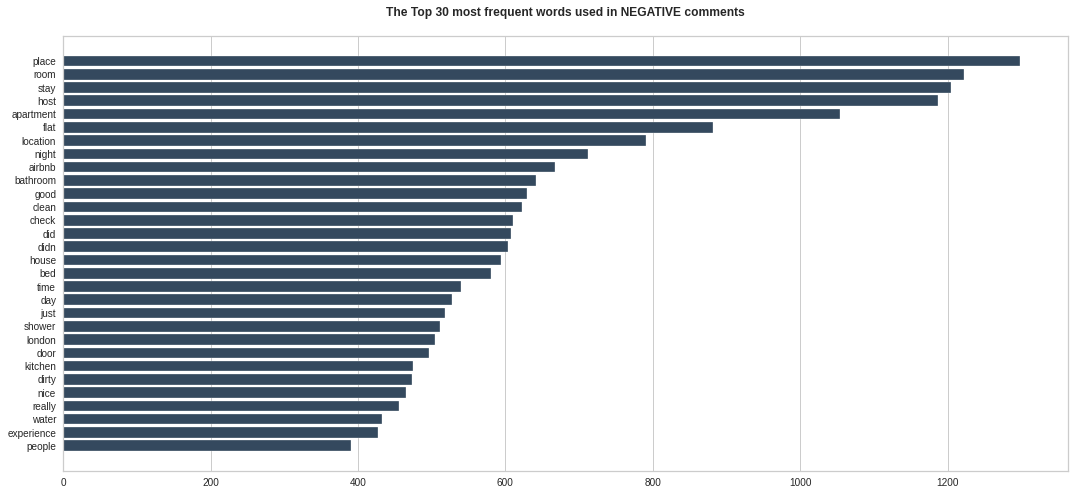

In [57]:
# now let's look at the Negative Comments
# vectorizing text
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

vectorizer = CountVectorizer(stop_words='english')
docs_neg = vectorizer.fit_transform(neg_comments)
features = vectorizer.get_feature_names()

# preparing the plot
set_palette('flatui')
plt.figure(figsize=(18,8))
plt.title('The Top 30 most frequent words used in NEGATIVE comments\n', fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(docs_neg)
visualizer.poof;

plt.savefig('data/raw/top30negative_comments.png')

In [126]:
# calling the cleaning function we defined earlier
doc_clean = [clean(comment).split() for comment in neg_comments]

In [127]:
# create a dictionary from the normalized data, convert this to a bag-of-words corpus
dictionary = corpora.Dictionary(doc_clean)
corpus = [dictionary.doc2bow(text) for text in doc_clean]

# save for later use
# uncomment the code if working locally
pickle.dump(corpus, open('data/raw/corpus_neg.pkl', 'wb'))
dictionary.save('data/raw/dictionary_neg.gensim')

In [128]:
# let LDA find 3 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

# uncomment the code if working locally
ldamodel.save('data/raw/model3_neg.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)
    
# results:
#(0, '0.013*"room" + 0.013*"place" + 0.011*"location" + 0.009*"apartment"')
#(1, '0.007*"die" + 0.007*"und" + 0.006*"la" + 0.006*"war"')
#(2, '0.013*"host" + 0.011*"u" + 0.009*"stay" + 0.009*"day"'

(0, '0.013*"room" + 0.013*"place" + 0.011*"location" + 0.009*"apartment"')
(1, '0.007*"die" + 0.007*"und" + 0.006*"la" + 0.006*"war"')
(2, '0.013*"host" + 0.011*"u" + 0.009*"stay" + 0.009*"day"')


In [130]:
# now let LDA find 5 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

ldamodel.save('data/raw/model5_neg.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

# results:
#(0, '0.005*"accommodation" + 0.004*"assistant" + 0.003*"lucy" + 0.003*"u"')
#(1, '0.014*"place" + 0.012*"host" + 0.009*"apartment" + 0.009*"flat"')
#(2, '0.014*"host" + 0.012*"u" + 0.012*"stay" + 0.010*"day"')
#(3, '0.010*"die" + 0.009*"und" + 0.009*"la" + 0.008*"war"')
#(4, '0.015*"room" + 0.011*"place" + 0.009*"location" + 0.009*"bathroom"')

(0, '0.005*"accommodation" + 0.004*"assistant" + 0.003*"lucy" + 0.003*"u"')
(1, '0.014*"place" + 0.012*"host" + 0.009*"apartment" + 0.009*"flat"')
(2, '0.014*"host" + 0.012*"u" + 0.012*"stay" + 0.010*"day"')
(3, '0.010*"die" + 0.009*"und" + 0.009*"la" + 0.008*"war"')
(4, '0.015*"room" + 0.011*"place" + 0.009*"location" + 0.009*"bathroom"')


In [131]:
# and finally 10 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

ldamodel.save('data/raw/model10_neg.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

# result:
#(0, '0.017*"host" + 0.014*"u" + 0.012*"day" + 0.011*"airbnb"')
#(1, '0.005*"avoid" + 0.004*"alex" + 0.004*"experience" + 0.004*"scaffolding"')
#(2, '0.017*"place" + 0.015*"close" + 0.013*"station" + 0.012*"apartment"')
#(3, '0.013*"room" + 0.009*"u" + 0.009*"dirty" + 0.009*"host"')
#(4, '0.023*"water" + 0.021*"flat" + 0.020*"shower" + 0.014*"hot"')
#(5, '0.030*"room" + 0.015*"bed" + 0.011*"place" + 0.010*"bathroom"')
#(6, '0.017*"de" + 0.014*"que" + 0.008*"no" + 0.008*"en"')
#(7, '0.016*"night" + 0.014*"location" + 0.012*"stop" + 0.012*"bus"')
#(8, '0.015*"location" + 0.015*"place" + 0.011*"london" + 0.010*"apartment"')
#(9, '0.015*"die" + 0.014*"und" + 0.012*"war" + 0.010*"da"')

(0, '0.017*"host" + 0.014*"u" + 0.012*"day" + 0.011*"airbnb"')
(1, '0.005*"avoid" + 0.004*"alex" + 0.004*"experience" + 0.004*"scaffolding"')
(2, '0.017*"place" + 0.015*"close" + 0.013*"station" + 0.012*"apartment"')
(3, '0.013*"room" + 0.009*"u" + 0.009*"dirty" + 0.009*"host"')
(4, '0.023*"water" + 0.021*"flat" + 0.020*"shower" + 0.014*"hot"')
(5, '0.030*"room" + 0.015*"bed" + 0.011*"place" + 0.010*"bathroom"')
(6, '0.017*"de" + 0.014*"que" + 0.008*"no" + 0.008*"en"')
(7, '0.016*"night" + 0.014*"location" + 0.012*"stop" + 0.012*"bus"')
(8, '0.015*"location" + 0.015*"place" + 0.011*"london" + 0.010*"apartment"')
(9, '0.015*"die" + 0.014*"und" + 0.012*"war" + 0.010*"da"')


In [132]:
dictionary = gensim.corpora.Dictionary.load('data/raw/dictionary_neg.gensim')

corpus = pickle.load(open('data/raw/corpus_neg.pkl', 'rb'))

In [134]:
# the follwing code need more memory and should be run locally only

# visualizing 5 topics
#lda = gensim.models.ldamodel.LdaModel.load('data/raw/model5_neg.gensim')

#lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
#pyLDAvis.display(lda_display)

In [ ]:
# End

# Executive Briefing

Module name: Introduction to Programming for Spatial Analysts (20/21)

Module number: CASA0013

Student ID: 20031364

Title: Information asymmetry and trust mechanisms in the sharing economy: Sentiment Analysis in London Airbnb

Word count: 2474 (including 3 figures)


## Executive Summary

With the rapid rise of the sharing economy in the post-21st century, sharing economy platforms, led by Airbnb and Uber, have become an important part of citizens' lives, which has attracted the attention of urban researchers, policy makers and activists (Wachsmuth and Weisler, 2018; Gurran and Phibbs, 2017). It is widely accepted that sharing economy hotels, by reducing energy consumption, waste generation, etc., are a more sustainable option than traditional travel accommodation (Midgett et al., 2017). However, the emergence of “Ghost hotel” has upset the balance of trust mechanisms in the sharing economy, while their circumvention of regulation has drawn the attention of governments and urban planners.

Therefore, natural language processing (NLP) and sentiment analysis using mainly python is used in this report to focus on the preferences and criticisms of renters in Airbnb London reviews. The data used for the study is review data from 16 December 2020, combined with some characteristics of detailed London listing data (same time), sourced from Inside Airbnb London.This paper uses sentiment analysis and visualisation of the review text to obtain the reasons why some tourists are disappointed with their stay at Airbnb London: (1) the level of hygiene, safety and comfort does not meet the standards of hotels; (2) the actual condition of the properties is not at the level described; (3) London is occupied by some giant rental companies and private individuals with huge funds. Ultimately, the recommendation of this report is to improve municipal oversight and enforcement of Airbnb as a short-term rental market, including hygiene, pricing, deceptive practices and the regulation of ghost hotels, through new legislation based on the previous law.

## Overview

### Ghost Hotel - An example of fraud on the Airbnb platform

In the absence of a specific and uniform definition of “ghost hotel” in the previous academic literature, this report will provide a subjective definition of ghost hotels in London for your better understanding and to set the scene for the data analysis that follows. Ghost hotels in this report refer to bogus hotels built for short term rentals created as a 'cover' for one or more listings in order to circumvent the 90-day short term rental limit in London (Wachsmuth and Weisler, 2018; The Greater London Assembly (General Powers) Act 1973). All of these listing accounts are essentially backed by the same person, or at least a company (hereafter referred to as the ghost maker). But their profiles all have something in common: they may all use panoramic images as profile pictures and they all use similar text in their profiles. This can be interpreted as a scam where, when a listing is close to being booked for a cumulative 90 days, the ghost maker will take down the listing and instead create one or more new listings to direct other tenants to continue renting the property. Thus, in the course of a year, a property may be rented for 180 or more days, generating far more profit in that period than would be earned in the long-term rental market (Midgett, 2017; Ferreri and Sanyal, 2018). From a regulatory perspective, this phenomenon is a side-effect of existing regulatory gaps: the 90-day rule for short term rentals in London applies to all platforms, but there is no provision to prevent landlords from offering the same property multiple times. The ghost hotel is just one of the many fraudulent practices in the sharing economy platform, which led me to think about the mechanism of the platform and the regulation of the government.

### The challenges of Airbnb and sharing economy

While there are many positive aspects of the sharing economy, such as community gardens, car sharing programs, and food co-ops (Cheng and Foley, 2018), Airbnb's advanced technological platform as a short-term home rental service connects travellers with hosts who have excess property capacity and can compete with traditional businesses (Sthapit and Björk, 2019; Wachsmuth and Weisler, 2018; Gurran and Phibbs, 2017). This also leads to Airbnb's first challenge to the sharing economy: whether the pursuit of profit deviates from the original purpose of sharing. In contrast to the socially driven logic of the sharing economy in general, Airbnb does so through a profit-driven base logic. This primarily includes providing homeowners with the ability to maximise their assets, such as the utility of a room, entire house or other property (Ferreri and Sanyal, 2018).Wachsmuth and Weisler (2018) argue that Airbnb and related platforms make it easier for landlords and property managers to rent out units as short-term rentals throughout the year, rather than as long-term residential rentals is easier and more profitable. For example, Ferreri and Sanyal (2018) suggest that some landlords circumvent local regulations on security and taxation and use the platform for holiday rentals to impact on the existing hospitality industry, but this goes beyond changing the traditional form of hosting travellers.Airbnb creates space for different stakeholders, including property developers, owners and tenants ( Cheng and Foley, 2018; Wachsmuth and Weisler, 2018), allowing tourist accommodation to permeate residential areas, which creates conflict between tourists and local residents, displacing permanent accommodation in high-demand cities and exacerbating affordability pressures on low-income groups (Gurran and Phibbs, 2017). As Shabrina, Arcaute and Batty (2019) claimed, it has become difficult for Londoners on middle or below average incomes to access home ownership, while exacerbating their plight in finding long-term rental housing.

The second sharing economy challenge is the trust mechanism, as early markets focused on selling products while sharing economy platforms provided services, so information asymmetry and economic risk raised the strong need for trust in sharing economy platforms (Ert, Fleischer and Magen, 2016). The sharing economy is called by different names in different markets, including the cooperative economy, cooperative consumption, co-production and consumer participation (Belk, 2014), however they share the common feature that there must be at least two objects involved. Thus, one's willingness to rely on a trading partner, i.e. trust, helps to reduce the anxiety, vulnerability, and uncertainty associated with trading (Sthapit and Björk, 2019). In the context of shared accommodation, mistrust is defined as a lack of interpersonal trust between guests and hosts and a lack of trust in Airbnb (Liang, Choi and Joppe, 2018). The inevitable limitations of social and mobile datasets on Airbnb, if not fully understood, can create disagreements and ethical omissions (Crawford and Finn, 2015). In summary, trust between service providers and consumers forms the basis of successful transactions in the sharing economy (Sthapit and Björk, 2019), which is particularly important in the case of Airbnb. It is the ghost hotels that challenge airbnb's trust system, as tenants cannot tell if the descriptions, reviews, and home addresses they see are genuine, which can lead to a gradual perception of the sharing economy as a fraudulent economy.

As the business models of firms in the sharing economy are disruptive of existing governance arrangements rather than existing market structures (Wachsmuth and Weisler, 2018). Last but not least, the third challenge of the sharing economy is the lack of a well-developed and robust regulatory regime, especially for world-class industry leaders like Airbnb. Despite the best efforts to protect the supply of long-term housing in London in section 25 of the Greater London Assembly (General Powers) Act 1973, the Deregulation Act (HM Government United Kingdom, 2015), enacted in May 2015, relaxed planning permission (Shabrina, Arcaute and Batty, 2019) which has made the government's complicity in shifting and suspending laws and regulations in order to encourage private enterprise and attract global corporate investment the subject of criticism (Ferreri and Sanyal, 2018). Cities have become hotbeds for the laissez-faire development of digital media (Ert, Fleischer and Magen, 2016), while the Airbnb platform has blurred the boundaries between hotels and housing, particularly across short-term rentals between housing and hotels this has led to a proliferation of ghost hotels. With over 49,000 listings in the London area alone as of October 2016 (Inside Airbnb London, 2017), the growing demand for tourism is putting pressure on the local housing market and impacting on existing plans for tourist and residential accommodation (Gurran and Phibbs, 2017). The government should try to reshape its regulatory environment by enacting new regulations, pilot policies for working with platforms, and macro control of the operational processes of shared services (Ferreri and Sanyal, 2018).

## Analysis

### Data Collection and Summary

This report uses two datasets (both from INSIDE Airbnb London), one is Detailed Listings data for London and the other is Detailed Review Data for listings in London. first, the report selected the columns needed in both datasets and then merged them into a combined dataset, mainly consisting of core data columns such as owner ID, property type, reviews, and location. The report then examines the top two homeowners in London in terms of the number of properties owned, and it is worth noting that the first place winner is a person or company that owns 352 properties in 19 boroughs.  This one heightened my suspicion that there are a large number of ghost hotels in London.

### Preprocessing the data

The raw data needed to be cleaned in order to prepare for the subsequent analysis.The first step was to remove the nulls, and once this was done the data set had a total of 1178411. However, too large a data set would have affected the speed of the subsequent research code, so a random sampling method was used to obtain a sample of 235,787 in 12 columns for this report. This was followed by the removal of punctuation and stopwords, which was done using the nltk.corpus package and the re package.

### Language Detection and Word Cloud Visualization

As reviewers in airbnb may come from all over the world, this leads to the fact that the language of the reviews may vary. Therefore, to ensure that the subsequent sentiment analysis can be carried out smoothly, this report will use the detect package to filter out the English reviews. It is important to note that the code runs heavily during the filtering process and the waiting time is long. In Figure 1, it can be seen that nearly 90% of the comments are in English, but there are still 10.13% of non-English comments, so filtering for language is an indispensable step.

Figure 1. The most frequent languages
![](data/raw/languages_comments.png)

### Sentiment analysis

Sentiment analysis is the process of working out whether a text is positive, negative or neutral and can be used in any situation where unstructured opinion data about an Airbnb service or product is available. In short, sentiment analysis can provide Airbnb or other sharing economy companies with a way to quickly find and prioritise these unhappy customers. The sentiment analysis approach in this report is based on a value-based approach, for example 'excellent' is more positive than 'good'. Also, the report mainly uses the VADER package, which is a type of sentiment analysis that is based on a lexicon of sentiment-related words. In this approach, each word in the lexicon is evaluated as positive or negative, and in many cases to what extent it is positive or negative.

In Figure 2. Sentiment Analysis of Airbnb Reviews for London, we can find that VADER produces four sentiment indicators from the ratings of these words. The first three are positive, neutral and negative, and the last indicator is the composite score, which is the rating of all the words. It is worth noting that these ratings have been standardised and range between -1 and 1.

Figure 2. Sentiment Analysis of Airbnb Reviews for London
![](data/raw/sentiment_analysis.png)

Finally, this report uses the method described to generate descriptive statistics summarising the central tendency and dispersion of the composite scores for the dataset. Also, the proportion of negative and positive reviews is compared (the output can be found in the GitHub link). It is clear that the majority of comments are very positive, but also contain 11.9% negative comments, which will be mentioned later in the analysis. Also, in Figure 3 it is noticeable that the text length pattern of the positive comments is further to the right than the negative comments, meaning that most positive comments are longer than most negative comments. But the negative reviews have a thicker tail.

Figure 3. Distribution plot for length of comments
![](data/raw/distribution.png)

### Comments investigation and topic modelling

Finally, this report uses the method described to generate descriptive statistics summarising the central tendency and dispersion of the composite scores for the dataset. Also, the proportion of negative and positive reviews is compared (the output can be found in the GitHub link). It is clear that the majority of comments are very positive, but also contain 11.9% negative comments, which will be mentioned later in the analysis. Also, in Figure 3 it is noticeable that the text length pattern of the positive comments is further to the right than the negative comments, meaning that most positive comments are longer than most negative comments. But the negative reviews have a thicker tail.

In this section, the report focuses on the text frequency distribution of positive and negative comments, such that the distribution can tell us how popular certain words are. Here we use the Yellowbrick library and the sklearn package. Due to space constraints, all output in this section is in github and zip files. Next we explore topic modelling, an unsupervised machine learning technique for abstracting topics from collections of documents, or in our case, for identifying topics being discussed in comments. In this section we look at a technique called Latent Dirichlet Allocation (LDA), which is a widely used topic modelling technique. First a topic is selected with a certain probability, then a word is selected with a certain probability under that topic, thus generating the first word of the document. This process is repeated over and over again to generate the whole article (assuming of course that there is no order between words, i.e. that all words are stacked in an unordered way in a large bag called a bag of words.

The results of top modelling tell us that the criteria for a positive rating are (1) short walking distances to restaurants and attractions and easy access to public transport, (2) a comfortable flat with a comfortable bed and clean kitchen, and (3) a wonderful breakfast. However, the negative comments were mainly focused on (1) the lack of hot water in the bathroom and the unclean rooms; (2) the noisy and poor soundproofing at night; and (3) the lack of conformity with the description given before the stay, i.e. some aspects did not meet the expectations of the visitors.

## Appendix

Code, raw data and resources generated from data analysis:
https://github.com/Zihaoli617/i2p_final_assessment


## References

Liang, L. J., Choi, H. C. and Joppe, M. (2018). ‘Exploring the relationship between satisfaction, trust and switching intention, repurchase intention in the context of Airbnb’. International Journal of Hospitality Management. doi: 10.1016/j.ijhm.2017.10.015.

Shabrina, Z., Arcaute, E. and Batty, M. (2019). ‘Airbnb’s disruption of the housing structure in london’. arXiv.

Wachsmuth, D. and Weisler, A. (2018). ‘Airbnb and the rent gap: Gentrification through the sharing economy’. Environment and Planning A. doi: 10.1177/0308518X18778038.

Belk, R. (2014). ‘You are what you can access: Sharing and collaborative consumption online’. Journal of Business Research. doi: 10.1016/j.jbusres.2013.10.001.

Ferreri, M. and Sanyal, R. (2018). ‘Platform economies and urban planning: Airbnb and regulated deregulation in London’. Urban Studies. doi: 10.1177/0042098017751982.

Midgett, C., Bendickson, J. S., Muldoon, J. and Solomon, S. J. (2017). ‘The Sharing Economy and Sustainability: A Case for Airbnb’. Small Business Institute Journal.

Sthapit, E. and Björk, P. (2019). ‘Sources of distrust: Airbnb guests’ perspectives’. Tourism Management Perspectives. doi: 10.1016/j.tmp.2019.05.009.

Crawford, K. and Finn, M. (2015). ‘The limits of crisis data: analytical and ethical challenges of using social and mobile data to understand disasters’. GeoJournal. doi: 10.1007/s10708-014-9597-z.

Ert, E., Fleischer, A. and Magen, N. (2016). ‘Trust and reputation in the sharing economy: The role of personal photos in Airbnb’. Tourism Management. doi: 10.1016/j.tourman.2016.01.013.

Cheng, M. and Foley, C. (2018). ‘The sharing economy and digital discrimination: The case of Airbnb’. International Journal of Hospitality Management. doi: 10.1016/j.ijhm.2017.11.002.

Gurran, N. and Phibbs, P. (2017). ‘When Tourists Move In: How Should Urban Planners Respond to Airbnb?’ Journal of the American Planning Association. doi: 10.1080/01944363.2016.1249011.

Melville, P., Gryc, W. and Lawrence, R. D. (2009). ‘Sentiment analysis of blogs by combining lexical knowledge with text classification’. in Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. doi: 10.1145/1557019.1557156.